# Tarea 6. Distribución óptima de capital y selección de portafolios.

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/en/f/f3/SML-chart.png" width="400px" height="400px" />

**Resumen.**
> En esta tarea, tendrás la oportunidad de aplicar los conceptos y las herramientas que aprendimos en el módulo 3. Específicamente, utilizarás técnicas de optimización media-varianza para construir la frontera de mínima varianza, encontrar el mejor portafolio sobre la frontera mínima varianza, y finalmente, identificar la asignación óptima de capital para un inversionista dado su nivel de averisón al riesgo.

**Criterio de revisión.**
> Se te calificará de acuerdo a los resultados finales que reportes, basados en tu análisis.

**Antes de comenzar.**
> Por favor, copiar y pegar este archivo en otra ubicación. Antes de comenzar, nombrarlo *Tarea6_ApellidoNombre*, sin acentos y sin espacios; por ejemplo, en mi caso el archivo se llamaría *Tarea6_JimenezEsteban*. Resolver todos los puntos en dicho archivo y subir en este espacio.

## 1. Datos (10 puntos)

Considere los siguientes datos de bonos, índice de acciones, mercados desarrollados, mercados emergentes, fondos privados, activos reales y activos libres de riesgo:

In [23]:
# Importamos pandas y numpy
import pandas as pd
import numpy as np

In [24]:
# Resumen en base anual de rendimientos esperados y volatilidades
annual_ret_summ = pd.DataFrame(columns=['Bonos', 'Acciones', 'Desarrollado', 'Emergente', 'Privados', 'Real', 'Libre_riesgo'], index=['Media', 'Volatilidad'])
annual_ret_summ.loc['Media'] = np.array([0.0400, 0.1060, 0.0830, 0.1190, 0.1280, 0.0620, 0.0300])
annual_ret_summ.loc['Volatilidad'] = np.array([0.0680, 0.2240, 0.2210, 0.3000, 0.2310, 0.0680, 0])

annual_ret_summ.round(4)

,Bonos,Acciones,Desarrollado,Emergente,Privados,Real,Libre_riesgo
Media,0.04,0.106,0.083,0.119,0.128,0.062,0.03
Volatilidad,0.068,0.224,0.221,0.3,0.231,0.068,0


In [25]:
# Matriz de correlación
corr = pd.DataFrame(data= np.array([[1.0000, 0.4000, 0.2500, 0.2000, 0.1500, 0.2000],
                                    [0.4000, 1.0000, 0.7000, 0.6000, 0.7000, 0.2000],
                                    [0.2500, 0.7000, 1.0000, 0.7500, 0.6000, 0.1000],
                                    [0.2000, 0.6000, 0.7500, 1.0000, 0.2500, 0.1500],
                                    [0.1500, 0.7000, 0.6000, 0.2500, 1.0000, 0.3000],
                                    [0.2000, 0.2000, 0.1000, 0.1500, 0.3000, 1.0000]]),
                    columns=annual_ret_summ.columns[:-1], index=annual_ret_summ.columns[:-1])
corr.round(4)

,Bonos,Acciones,Desarrollado,Emergente,Privados,Real
Bonos,1.00,0.4,0.25,0.20,0.15,0.20
Acciones,0.40,1.0,0.70,0.60,0.70,0.20
Desarrollado,0.25,0.7,1.00,0.75,0.60,0.10
Emergente,0.20,0.6,0.75,1.00,0.25,0.15
Privados,0.15,0.7,0.60,0.25,1.00,0.30
Real,0.20,0.2,0.10,0.15,0.30,1.00


1. Graficar en el espacio de rendimiento esperado contra volatilidad cada uno de los activos (10 puntos).

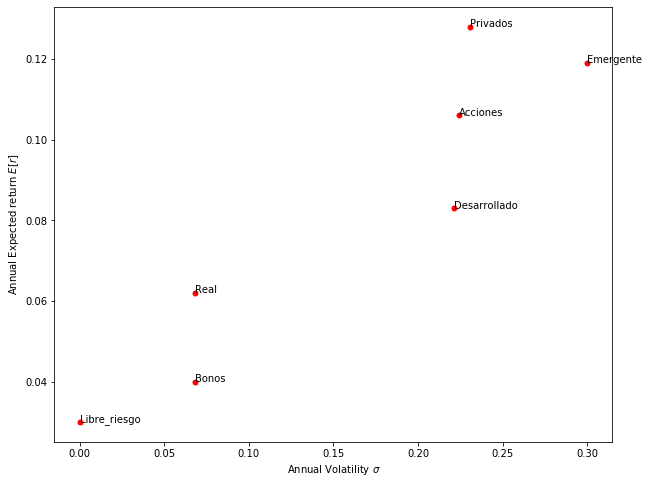

In [26]:
import matplotlib.pyplot as plt
# Gráfico rendimiento esperado vs. volatilidad
x_points = annual_ret_summ.loc['Volatilidad'].values
y_points = annual_ret_summ.loc['Media'].values
plt.figure(figsize=(10,8))
plt.plot(x_points, y_points, 'ro', ms=5)
plt.xlabel('Annual Volatility $\sigma$')
plt.ylabel('Annual Expected return $E[r]$')
#Etiqueta de cada instrumento
for i in range(0,7):
    plt.text(x_points[i], y_points[i],annual_ret_summ.columns[i])

## 2. Hallando portafolios sobre la frontera de mínima varianza (35 puntos)

Usando los datos del punto anterior:

1. Halle los pesos del portafolio de mínima varianza considerando todos los activos riesgosos. También reportar claramente el rendimiento esperado, volatilidad y cociente de Sharpe para dicho portafolio (15 puntos).
2. Halle los pesos del portafolio EMV considerando todos los activos riesgosos. También reportar claramente el rendimiento esperado, volatilidad y cociente de Sharpe para dicho portafolio (15 puntos).
3. Halle la covarianza y la correlación entre los dos portafolios hallados (5 puntos)

In [5]:
# Importamos funcion minimize del modulo optimize de scipy
from scipy.optimize import minimize

In [6]:
rf = annual_ret_summ.iloc[0,-1]
annual_ret_summ = annual_ret_summ.iloc[:, :-1]

In [7]:
## Construcción de parámetros
# 1. Sigma: matriz de varianza-covarianza Sigma = S.dot(corr).dot(S)
S = np.diag(annual_ret_summ.loc['Volatilidad', :].values)
Sigma = S.dot(corr).dot(S)
# 2. Eind: rendimientos esperados activos individuales
Eind = annual_ret_summ.loc['Media', :].values

In [8]:
# Función objetivo
def varianza(w, Sigma):
    return w.T.dot(Sigma).dot(w)

In [9]:
# Dato inicial
n = len(Eind)
w0 = np.ones(n) / n
# Cotas de las variables
bnds = ((0, 1),) * n
# Restricciones
cons = {'type': 'eq', 'fun': lambda w: w.sum() - 1}

In [10]:
# Portafolio de mínima varianza
minvar = minimize(fun=varianza, x0=w0, args=(Sigma,), bounds=bnds, constraints=cons)
minvar

     fun: 0.0027745037325952863
     jac: array([0.00551408, 0.00912289, 0.00525779, 0.00714968, 0.00710235,
       0.0055834 ])
 message: 'Optimization terminated successfully.'
    nfev: 64
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([4.95146500e-01, 0.00000000e+00, 2.09837058e-04, 4.33680869e-19,
       0.00000000e+00, 5.04643663e-01])

In [11]:
# Pesos, rendimiento y riesgo del portafolio de mínima varianza
w_minvar = minvar.x
E_minvar = Eind.T.dot(w_minvar)
s_minvar = (w_minvar.T.dot(Sigma).dot(w_minvar))**0.5

def minus_SR(w, Sigma, Eind, rf):
    sp = (w.T.dot(Sigma).dot(w))**0.5
    Ep = Eind.T.dot(w)
    SR = (Ep - rf) / sp
    return -SR

SR_minvar = -minus_SR(w_minvar,s_minvar,annual_ret_summ.loc["Media"],rf)

In [12]:
print("Los pesos del portafolio de minima varianza son, respectivamente",w_minvar," Con un rendimiento de",E_minvar," y una volatilidad de ",s_minvar, " y un índice de sharpe de",SR_minvar)

Los pesos del portafolio de minima varianza son, respectivamente [4.95146500e-01 0.00000000e+00 2.09837058e-04 4.33680869e-19
 0.00000000e+00 5.04643663e-01]  Con un rendimiento de 0.0511111835712562  y una volatilidad de  0.0526735581918982  y un índice de sharpe de 0.1301076341940257


In [13]:
#EMV

# Dato inicial
n = len(Eind)
w0 = np.ones(n) / n
# Cotas de las variables
bnds = ((0, 1),) * n
# Restricciones
cons = {'type': 'eq', 'fun': lambda w: w.sum() - 1}
# Portafolio EMV
EMV = minimize(fun=minus_SR, x0=w0, args=(Sigma, Eind, rf), bounds=bnds, constraints=cons)
EMV

     fun: -0.5811986201269204
     jac: array([-0.36522095, -0.28920724, -0.12258474, -0.36597763, -0.36617207,
       -0.36620118])
 message: 'Optimization terminated successfully.'
    nfev: 50
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([1.34289953e-17, 1.01738175e-16, 1.23637069e-16, 8.19187951e-02,
       1.65859031e-01, 7.52222174e-01])

In [14]:
# Pesos, rendimiento y riesgo del portafolio EMV
w_EMV = EMV.x
E_EMV = Eind.T.dot(w_EMV)
s_EMV = (w_EMV.T.dot(Sigma).dot(w_EMV))**0.5
w_EMV, E_EMV, s_EMV
SR_EMV = -minus_SR(w_EMV,s_EMV,annual_ret_summ.loc["Media"],rf)


In [15]:
print("Los pesos del portafolio EMV son, respectivamente",w_EMV," Con un rendimiento de",E_EMV," y una volatilidad de ",s_EMV, " y un índice de sharpe de",SR_EMV)

Los pesos del portafolio EMV son, respectivamente [1.34289953e-17 1.01738175e-16 1.23637069e-16 8.19187951e-02
 1.65859031e-01 7.52222174e-01]  Con un rendimiento de 0.0776160673678556  y una volatilidad de  0.0819273579098611  y un índice de sharpe de 0.2147545607896808


In [16]:
# Covarianza entre los portafolios
cov = w_EMV.T.dot(Sigma).dot(w_minvar)
# Correlación entre los portafolios
corr = cov / (s_EMV * s_minvar)

print("La covarianza entre los dos portafolios es de ",cov,"con una correlación de",corr)

La covarianza entre los dos portafolios es de  0.00298181903668825 con una correlación de 0.6909707716261658


## 3. Frontera de mínima varianza y LAC (30 puntos)

Con los portafolios que se encontraron en el punto anterior (de mínima varianza y EMV):

1. Construya la frontera de mínima varianza calculando el rendimiento esperado y volatilidad para varias combinaciones de los anteriores portafolios. Reportar dichas combinaciones en un DataFrame incluyendo pesos, rendimiento, volatilidad y cociente de Sharpe (15 puntos).
2. También construya la línea de asignación de capital entre el activo libre de riesgo y el portafolio EMV. Reportar las combinaciones de estos activos en un DataFrame incluyendo pesos, rendimiento, volatilidad y cociente de Sharpe (15 puntos).

In [17]:
from matplotlib import pyplot as plt
%matplotlib inline
# Vector de w
w = np.linspace(0, 3, 100)

portafolios = pd.DataFrame(data={'w': w, 
                                 '1-w': 1 - w,
                                 'Media': w * E_EMV + (1 - w) * E_minvar,
                                 'Vol': ((w * s_EMV)**2 + ((1 - w) * s_minvar)**2 + 2 * w * (1 - w) * cov)**0.5                             })
portafolios['RS'] = (portafolios['Media'] - rf) / portafolios['Vol']
portafolios.head()

,w,1-w,Media,Vol,RS
0,0.000000,1.000000,0.051111,0.052674,0.400793
1,0.030303,0.969697,0.051914,0.052823,0.414861
2,0.060606,0.939394,0.052718,0.053034,0.428360
3,0.090909,0.909091,0.053521,0.053304,0.441256
4,0.121212,0.878788,0.054324,0.053633,0.453523


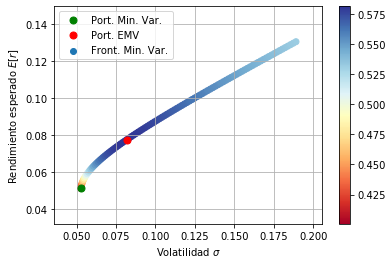

In [18]:
# Gráfica de dispersión de puntos coloreando 
# de acuerdo a SR, los activos individuales
# y los portafolios hallados
plt.figure(figsize=(6, 4))
plt.scatter(portafolios['Vol'], portafolios['Media'], c=portafolios['RS'], cmap='RdYlBu', label='Front. Min. Var.')
plt.plot(s_minvar, E_minvar, 'og', ms=7, label='Port. Min. Var.')
plt.plot(s_EMV, E_EMV, 'or', ms=7, label='Port. EMV')
plt.legend(loc='best')
plt.colorbar()
plt.xlabel("Volatilidad $\sigma$")
plt.ylabel("Rendimiento esperado $E[r]$")
plt.grid()

In [51]:
# Vector de wp variando entre 0 y 1.5 con n pasos
N = 50
wp = np.linspace(0, 1.8, N)

LAC = pd.DataFrame(index=range(N), data={'wp': wp, 
                                         'wrf': 1 - wp,
                                         'Media': wp * E_EMV + (1 - wp) * rf,
                                         'Vol': wp * s_EMV
                                        })
LAC['RS'] = (LAC['Media'] - rf) / LAC['Vol']
LAC.tail()

,wp,wrf,Media,Vol,RS
45,1.653061,-0.653061,0.108712,0.135431,0.581199
46,1.689796,-0.689796,0.110461,0.138441,0.581199
47,1.726531,-0.726531,0.112211,0.141450,0.581199
48,1.763265,-0.763265,0.113960,0.144460,0.581199
49,1.800000,-0.800000,0.115709,0.147469,0.581199


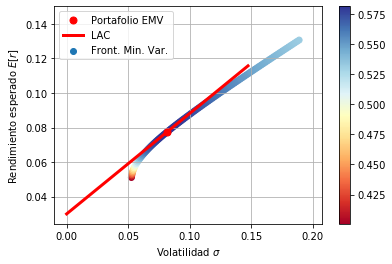

In [39]:
# Gráfica de dispersión de puntos coloreando 
# de acuerdo a SR, portafolio EMV y LAC
plt.figure(figsize=(6, 4))
plt.scatter(portafolios['Vol'], portafolios['Media'], c=portafolios['RS'], cmap='RdYlBu', label='Front. Min. Var.')
plt.plot(s_EMV, E_EMV, 'or', ms=7, label='Portafolio EMV')
plt.plot(LAC['Vol'], LAC['Media'], lw=3, label='LAC',c="r")
plt.legend()
plt.colorbar()
plt.xlabel("Volatilidad $\sigma$")
plt.ylabel("Rendimiento esperado $E[r]$")
plt.grid()

## 4. Gráficos y conclusiones (25 puntos)

1. Usando todos los datos obtenidos, grafique:
 - los activos individuales,
 - portafolio de mínima varianza,
 - portafolio eficiente en media-varianza (EMV),
 - frontera de mínima varianza, y
 - línea de asignación de capital,
en el espacio de rendimiento (eje $y$) vs. volatilidad (eje $x$). Asegúrese de etiquetar todo y poner distintos colores para diferenciar los distintos elementos en su gráfico (15 puntos).
2. Suponga que usted está aconsejando a un cliente cuyo coeficiente de aversión al riesgo resultó ser 4. ¿Qué asignación de capital le sugeriría?, ¿qué significa su resultado?(10 puntos)

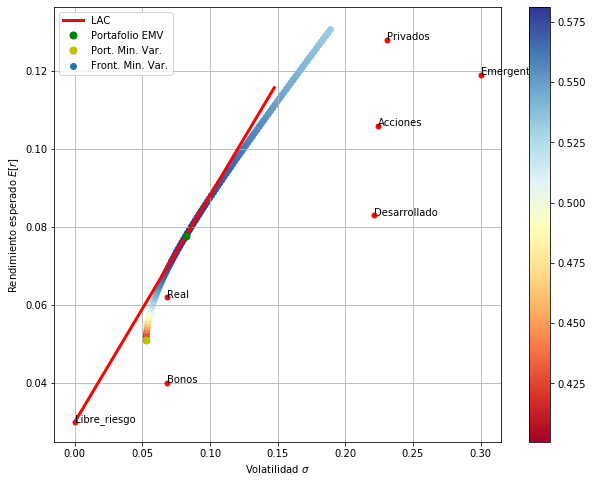

In [40]:
plt.figure(figsize=(10, 8))
plt.plot(x_points, y_points, 'ro', ms=5)
for i in range(0,7):
    plt.text(x_points[i], y_points[i],annual_ret_summ.columns[i])
plt.scatter(portafolios['Vol'], portafolios['Media'], c=portafolios['RS'], cmap='RdYlBu', label='Front. Min. Var.')
plt.plot(LAC['Vol'], LAC['Media'], lw=3, label='LAC',c="r")
plt.plot(s_EMV, E_EMV, 'og', ms=7, label='Portafolio EMV')
plt.plot(s_minvar, E_minvar, 'oy', ms=7, label='Port. Min. Var.')
plt.legend()
plt.colorbar()
plt.xlabel("Volatilidad $\sigma$")
plt.ylabel("Rendimiento esperado $E[r]$")
plt.grid()

In [44]:
g = 4
w_a = (E_EMV - rf) / (g * s_EMV**2)
w_a, 1 - w_a

(1.7735181353168143, -0.7735181353168143)

In [45]:
print("Si el coeficiente del cliente es 4, entonces recomendaría pedir prestado ",1-w_a,"veces el capital e invertir el capital más lo prestado, resultando ",w_a,"en el portafolio EMV")

Si el coeficiente del cliente es 4, entonces recomendaría pedir prestado  -0.7735181353168143 veces el capital e invertir el capital más lo prestado, resultando  1.7735181353168143 en el portafolio EMV


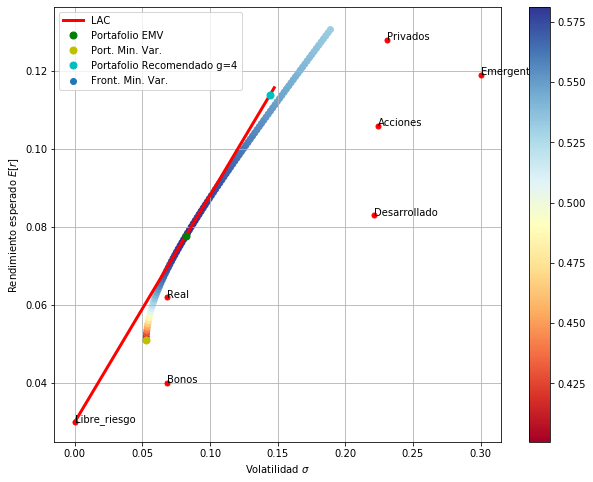

In [53]:
plt.figure(figsize=(10, 8))
plt.plot(x_points, y_points, 'ro', ms=5)
for i in range(0,7):
    plt.text(x_points[i], y_points[i],annual_ret_summ.columns[i])
plt.scatter(portafolios['Vol'], portafolios['Media'], c=portafolios['RS'], cmap='RdYlBu', label='Front. Min. Var.')
plt.plot(LAC['Vol'], LAC['Media'], lw=3, label='LAC',c="r")
plt.plot(s_EMV, E_EMV, 'og', ms=7, label='Portafolio EMV')
plt.plot(s_minvar, E_minvar, 'oy', ms=7, label='Port. Min. Var.')
plt.plot(LAC.loc[:,"Vol"][48], LAC.loc[:,"Media"][48], 'oc', ms=7, label='Portafolio Recomendado g=4')
plt.legend()
plt.colorbar()
plt.xlabel("Volatilidad $\sigma$")
plt.ylabel("Rendimiento esperado $E[r]$")
plt.grid()

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>